
# Job Listings: Exploratory Analysis & Clustering Notebook

This notebook loads your **pickled job listings** (list of dictionaries), performs **exploratory data analysis (EDA)**, and runs multiple **clustering** approaches to identify role archetypes and market structures.

**What you get:**
- Compensation EDA (distributions, boxplots, pay by job family/seniority/work mode)
- Skill demand analysis (frequency, co-occurrence heatmap)
- Text-based exploration of responsibilities and descriptions (TF–IDF)
- Clustering:
  - **Skill-based KMeans** clusters
  - **Text (TF–IDF)** KMeans clusters
  - Optional Agglomerative / DBSCAN variants
- 2D visualizations via PCA for cluster interpretation
- Human-readable **archetype summaries** (top skills/terms per cluster)

In [33]:

# =============================
# 1. Configuration & Imports
# =============================
import os
import re
import math
import pickle
import itertools
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# ---- Config ----
PKL_PATH = "data/result.pkl"  

# Where to write outputs (CSV with cluster labels, figures, etc.)
OUTPUT_DIR = "cluster_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Using PKL_PATH =", PKL_PATH)
print("Outputs will be saved to", os.path.abspath(OUTPUT_DIR))


Using PKL_PATH = data/result.pkl
Outputs will be saved to /Users/ashwinayyasamy/Mercor Project/cluster_outputs


In [34]:
# ================================
# Load + Normalize in one function
# ================================
import pickle
import pandas as pd
import numpy as np

LIST_COLS = ["industry_tags", "required_technologies", "responsibilities"]

def _ensure_list(val):
    if isinstance(val, list):
        return val
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return []
    return [val]

def load_normalized_listings(pkl_path: str) -> pd.DataFrame:
    """
    Works with:
      - dict[str, dict]: outer keys are listing_ids  (your current PKL format)
      - list[dict]: list of job dicts
    Returns a flat DataFrame with key fields + comp_mid, ready for EDA/clustering.
    """
    data = pickle.load(open(pkl_path, "rb"))

    # --- Step 1: Base frame (keep outer key if dict) ---
    if isinstance(data, dict):
        base = pd.DataFrame.from_dict(data, orient="index")
        base.rename_axis("outer_key", inplace=True)          # preserve outer key
        base.reset_index(inplace=True)
    elif isinstance(data, (list, tuple)):
        base = pd.DataFrame(list(data))
        base.insert(0, "outer_key", pd.Series([None]*len(base)))
    else:
        raise ValueError("PKL must be a dict-of-dicts or list-of-dicts.")

    # --- Step 2: Make sure llm_ie is a dict everywhere ---
    if "llm_ie" not in base.columns:
        base["llm_ie"] = [{} for _ in range(len(base))]
    base["llm_ie"] = base["llm_ie"].apply(lambda x: x if isinstance(x, dict) else {})

    # --- Step 3: Flatten the llm_ie fields you actually use ---
    llm_flat = pd.json_normalize(base["llm_ie"])
    # keep only the columns you rely on downstream
    keep_map = {
        "job_family": "job_family",
        "seniority_level": "seniority_level",
        "industry_tags": "industry_tags",
        "required_technologies": "required_technologies",
        "responsibilities": "responsibilities",
    }
    llm_flat = llm_flat.reindex(columns=list(keep_map.keys()))
    llm_flat.columns = list(keep_map.values())

    # --- Step 4: Combine & tidy ---
    out = pd.concat(
        [base.drop(columns=["llm_ie"], errors="ignore"), llm_flat],
        axis=1
    )

    # If inner dict missed listing_id, fall back to outer_key
    if "listing_id" not in out.columns:
        out["listing_id"] = out["outer_key"]
    else:
        out["listing_id"] = out["listing_id"].fillna(out["outer_key"])

    # Ensure list-typed columns are lists
    for c in LIST_COLS:
        if c not in out.columns:
            out[c] = [[] for _ in range(len(out))]
        out[c] = out[c].apply(_ensure_list)

    # Text field present
    if "raw_text" not in out.columns:
        out["raw_text"] = ""

    # Compensation to numeric
    for c in ["comp_low", "comp_high"]:
        out[c] = pd.to_numeric(out.get(c), errors="coerce")
    out["comp_mid"] = (out["comp_low"] + out["comp_high"]) / 2.0

    # Keep the columns your notebook expects (others are fine to keep too)
    cols_order = [
        "listing_id","title","company","employment_type","work_mode",
        "comp_low","comp_high","comp_unit","comp_mid",
        "job_family","seniority_level","industry_tags",
        "required_technologies","responsibilities","raw_text"
    ]
    # Add any missing columns as empty
    for c in cols_order:
        if c not in out.columns:
            out[c] = [] if c in LIST_COLS else ("" if c == "raw_text" else np.nan)

    return out[cols_order]


In [35]:
df = load_normalized_listings(PKL_PATH)
print("Loaded rows:", len(df))
print(df.head())
print("\nColumns:", df.columns.tolist())

Loaded rows: 199
                      listing_id  \
0  list_AAABmEMeZ2IV7PVfMfJKxon3   
1  list_AAABmKQRJLAmaJFh2MhHo4QK   
2  list_AAABmCxLNGrnqFbkyAZJ64x4   
3  list_AAABmHvc9emtmP_JbQZI_a_d   
4  list_AAABmHvEGc-qxYNoCZtB4LY3   

                                               title company  employment_type  \
0                                      Dutch Lawyers  Mercor  Hourly Contract   
1                     Exceptional Software Engineers  Mercor  Hourly Contract   
2  Health Information Technologists and Medical R...  Mercor  Hourly Contract   
3           Competition-Level Math Evaluator - India  Mercor  Hourly Contract   
4         Scientific Coding Evaluator - STEM (India)  Mercor  Hourly Contract   

  work_mode  comp_low  comp_high comp_unit  comp_mid         job_family  \
0    Remote     120.0      180.0      hour     150.0              legal   
1    Remote      50.0      100.0      hour      75.0  software_engineer   
2    Remote      60.0      110.0      hour      85.0  

Shape: (199, 15)

Null counts:
 listing_id               0
title                    0
company                  0
employment_type          0
work_mode                7
comp_low                 0
comp_high                0
comp_unit                0
comp_mid                 0
job_family               0
seniority_level          0
industry_tags            0
required_technologies    0
responsibilities         0
raw_text                 0
dtype: int64

Job families (top 20):
 job_family
other                96
legal                29
software_engineer    21
evaluator            18
ops                  15
analyst              10
design                4
sales                 2
ml_engineer           2
product               1
data_science          1
Name: count, dtype: int64

Seniority levels:
 seniority_level
Multiple/Unclear    111
Mid                  70
Senior               10
Junior                5
Intern                3
Name: count, dtype: int64

Work modes:
 work_mode
Remote    192
Name

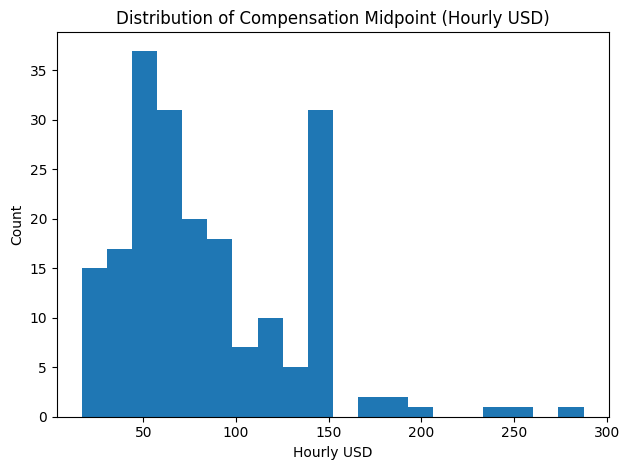

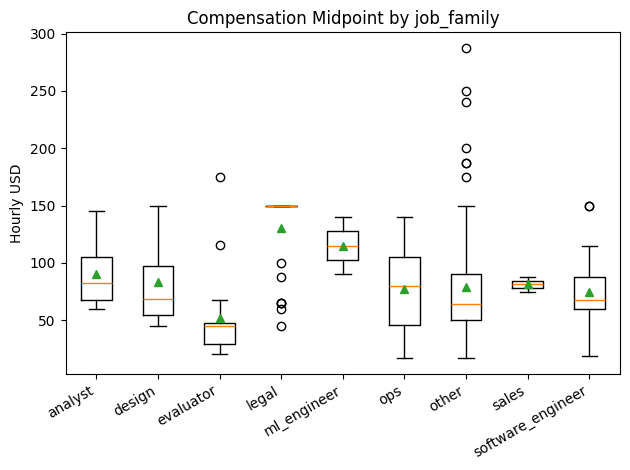

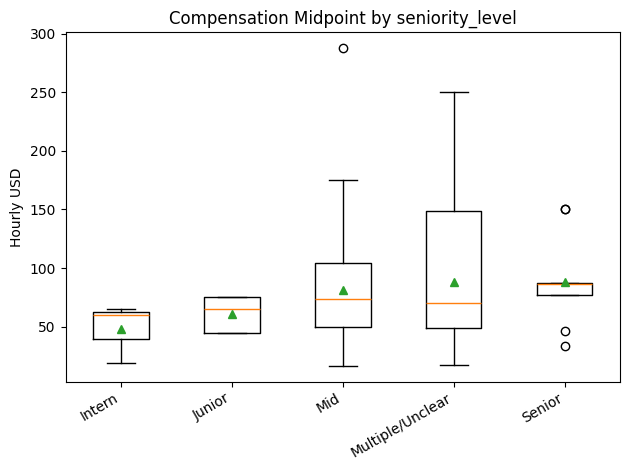

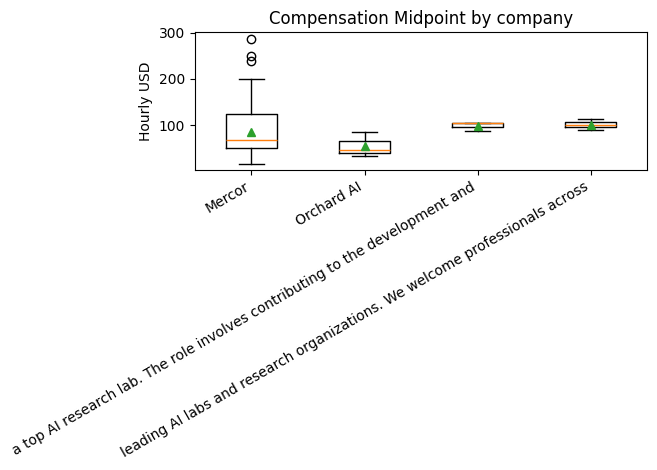

In [36]:

# =====================
# 4. Basic EDA & sanity
# =====================
print("Shape:", df.shape)
print("\nNull counts:\n", df.isnull().sum())

print("\nJob families (top 20):\n", df['job_family'].value_counts().head(20))
print("\nSeniority levels:\n", df['seniority_level'].value_counts())
print("\nWork modes:\n", df['work_mode'].value_counts())

print("\nCompensation (hourly USD assumed):")
print(df[['comp_low','comp_high','comp_mid']].describe())

plt.figure()
plt.hist(df['comp_mid'].dropna().values, bins=20)
plt.title("Distribution of Compensation Midpoint (Hourly USD)")
plt.xlabel("Hourly USD")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

def safe_boxplot(col):
    vals = df.groupby(col)['comp_mid'].apply(list).to_dict()
    labels = []
    data = []
    for k, v in vals.items():
        if isinstance(v, list) and len(v) >= 2:
            labels.append(k)
            data.append(v)
    if data:
        plt.figure()
        plt.boxplot(data, showmeans=True)
        plt.xticks(range(1,len(labels)+1), labels, rotation=30, ha='right')
        plt.title(f"Compensation Midpoint by {col}")
        plt.ylabel("Hourly USD")
        plt.tight_layout()
        plt.show()

for group_col in ['job_family', 'seniority_level', 'work_mode', 'company']:
    if df[group_col].nunique() > 1:
        safe_boxplot(group_col)


Top 25 required skills:
Python          17
JavaScript       6
Java             6
Go               6
TypeScript       5
Docker           5
React            5
C++              5
Flask            4
API              4
Rust             4
Typescript       3
PostgreSQL       3
Google Cloud     3
pandas           3
C                3
SciPy            2
NumPy            2
Node.js          1
R                1
Go (Golang)      1
FHIR             1
HL7              1
DICOM            1
Excel            1
dtype: int64


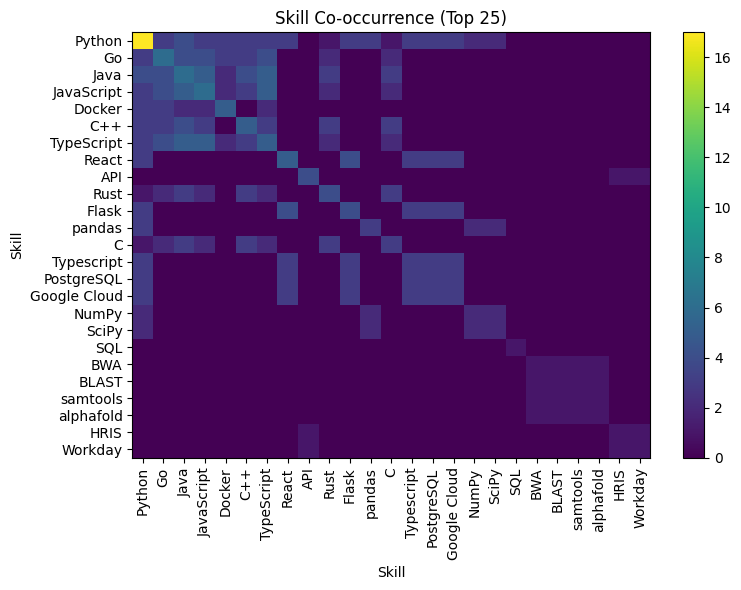

In [37]:

# =========================================
# 5. Skill Frequency & Co-occurrence Heatmap
# =========================================
import numpy as np
import itertools
from collections import Counter

skills_series = df['required_technologies'].apply(lambda x: x if isinstance(x, list) else [])
all_skills = list(itertools.chain.from_iterable(skills_series))
skill_counts = Counter([s.strip() for s in all_skills if isinstance(s, str) and s.strip()])

print("Top 25 required skills:")
print(pd.Series(skill_counts).sort_values(ascending=False).head(25))

TOP_K = 25
top_skills = [s for s,_ in sorted(skill_counts.items(), key=lambda kv: kv[1], reverse=True)[:TOP_K]]
skill_to_idx = {s:i for i,s in enumerate(top_skills)}
co_mat = np.zeros((len(top_skills), len(top_skills)), dtype=int)

for skills in skills_series:
    sset = [s for s in skills if s in skill_to_idx]
    for i, j in itertools.combinations_with_replacement(sset, 2):
        ii, jj = skill_to_idx[i], skill_to_idx[j]
        co_mat[ii, jj] += 1
        if ii != jj:
            co_mat[jj, ii] += 1

plt.figure(figsize=(8,6))
plt.imshow(co_mat, aspect='auto')
plt.title("Skill Co-occurrence (Top 25)")
plt.xlabel("Skill")
plt.ylabel("Skill")
plt.xticks(ticks=range(len(top_skills)), labels=top_skills, rotation=90)
plt.yticks(ticks=range(len(top_skills)), labels=top_skills)
plt.colorbar()
plt.tight_layout()
plt.show()


Skill feature matrix shape: (199, 76)
Best K (skills): 2 with silhouette 0.832
cluster_skills_kmeans
0      1
1    198
Name: count, dtype: int64

Top skills per skill-cluster:
Cluster 0: ['ADP(1)', 'API(1)', 'BambooHR(1)', 'HRIS(1)', 'Microsoft 365(1)', 'SAP SuccessFactors(1)', 'Workday(1)', 'ANSYS(0)', 'APIs(0)', 'Adobe Creative Cloud(0)', 'Adobe Photoshop(0)', 'Asana(0)']
Cluster 1: ['Python(17)', 'Go(6)', 'Java(6)', 'JavaScript(6)', 'C++(5)', 'Docker(5)', 'React(5)', 'TypeScript(5)', 'Flask(4)', 'Rust(4)', 'API(3)', 'C(3)']


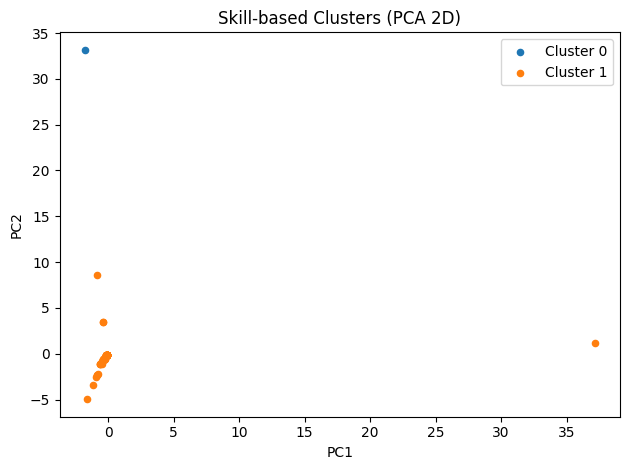

In [38]:

# ==================================
# 6. Clustering A: Skill-based KMeans
# ==================================
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

mlb = MultiLabelBinarizer(sparse_output=False)
X_skills = mlb.fit_transform(skills_series)
skill_feature_names = mlb.classes_
print("Skill feature matrix shape:", X_skills.shape)

scaler = StandardScaler(with_mean=False)
X_skills_scaled = scaler.fit_transform(X_skills)

def best_kmeans(X, k_range=range(2, 8)):
    best_k, best_score, best_model = None, -1, None
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(X)
        if len(set(labels)) < 2:
            continue
        try:
            score = silhouette_score(X, labels)
        except Exception:
            score = -1
        if score > best_score:
            best_k, best_score, best_model = k, score, km
    return best_k, best_score, best_model

k_best, sil, kmeans_model = best_kmeans(X_skills_scaled)
print(f"Best K (skills): {k_best} with silhouette {sil:.3f}" if k_best else "Could not determine a best K")

if kmeans_model:
    df['cluster_skills_kmeans'] = kmeans_model.predict(X_skills_scaled)
    print(df['cluster_skills_kmeans'].value_counts().sort_index())
else:
    df['cluster_skills_kmeans'] = -1

def top_skills_for_cluster(labels, X_bin, feature_names, topn=10):
    out = {}
    for c in sorted(set(labels)):
        if c == -1:
            continue
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue
        sums = X_bin[idx].sum(axis=0)
        pairs = sorted(zip(feature_names, sums), key=lambda kv: kv[1], reverse=True)[:topn]
        out[c] = pairs
    return out

skill_tops = top_skills_for_cluster(df['cluster_skills_kmeans'].values, X_skills, skill_feature_names, topn=12)
print("\nTop skills per skill-cluster:")
for c, pairs in skill_tops.items():
    print(f"Cluster {c}: {[f'{k}({int(v)})' for k,v in pairs]}")

if X_skills.shape[0] >= 2 and X_skills.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(X_skills_scaled)
    plt.figure()
    for c in sorted(set(df['cluster_skills_kmeans'])):
        mask = (df['cluster_skills_kmeans'] == c)
        plt.scatter(coords[mask,0], coords[mask,1], label=f"Cluster {c}", s=20)
    plt.title("Skill-based Clusters (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


TF–IDF matrix shape: (199, 5000)
Best K (text): 7 with silhouette 0.218

Top TF–IDF terms per text-cluster:
Cluster 0: ['content', 'reasoning', 'scientific', 'ai', 'stem', 'english', 'review', 'feedback', 'generated', 'mercor', 'technical', 'structured']
Cluster 1: ['project', 'note', 'work', 'based', 'hourly compensation', 'questions related', 'design questions', 'occupation', 'related occupation', 'scale', 'services', 'professional']
Cluster 2: ['ai', 'mercor', 'product', 'research', 'experts', 'accounting', 'project', 'leading', 'experience', 'workflows', 'professionals', 'leading ai']
Cluster 3: ['write', 'ai', 'documentation', 'ai models', 'language', 'day', 'domain', 'help', 'local language', 'write documentation', 'write ups', 'provide linguistic']
Cluster 4: ['software', 'open source', 'code', 'source', 'unit', 'engineer', 'mercor', 'ai', 'orchard', 'repositories', 'tests', 'performance']
Cluster 5: ['ai', 'mercor', 'prompt', 'systems', 'apply', 'interview', 'software', 'techni

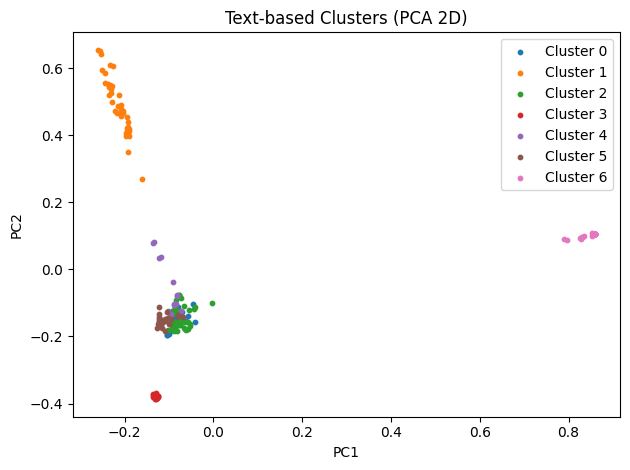

In [39]:

# ==================================
# 7. Clustering B: Text (TF–IDF) KMeans
# ==================================
def join_list(x):
    return " ; ".join(x) if isinstance(x, list) else (x or "")

corpus = (
    df['title'].fillna('').astype(str) + " | " +
    df['responsibilities'].apply(join_list).astype(str) + " | " +
    df['raw_text'].fillna('').astype(str)
).tolist()

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2, stop_words="english")
X_text = tfidf.fit_transform(corpus)
print("TF–IDF matrix shape:", X_text.shape)

k_best_text, sil_text, kmeans_text = None, -1, None
for k in range(2, 8):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_text)
    if len(set(labels)) < 2:
        continue
    score = silhouette_score(X_text, labels)
    if score > sil_text:
        k_best_text, sil_text, kmeans_text = k, score, km

if kmeans_text is None:
    k_best_text = 5
    kmeans_text = KMeans(n_clusters=5, n_init=10, random_state=42).fit(X_text)
    print("Using default k=5 for text clusters.")
else:
    print(f"Best K (text): {k_best_text} with silhouette {sil_text:.3f}")

df['cluster_text_kmeans'] = kmeans_text.predict(X_text)

def top_terms_per_cluster(km_model, vectorizer, topn=12):
    terms = vectorizer.get_feature_names_out()
    centers = km_model.cluster_centers_
    out = {}
    for i, center in enumerate(centers):
        top_idx = np.argsort(center)[::-1][:topn]
        out[i] = [terms[j] for j in top_idx]
    return out

text_tops = top_terms_per_cluster(kmeans_text, tfidf, topn=12)
print("\nTop TF–IDF terms per text-cluster:")
for c, terms in text_tops.items():
    print(f"Cluster {c}: {terms}")

# PCA 2D scatter (on dense array for small/medium sets)
try:
    X_dense = X_text.toarray()
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(X_dense)
    labels_plot = df['cluster_text_kmeans'].values
    plt.figure()
    for c in sorted(set(labels_plot)):
        mask = (labels_plot == c)
        plt.scatter(coords[mask,0], coords[mask,1], s=10, label=f"Cluster {c}")
    plt.title("Text-based Clusters (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Skipping PCA scatter for text due to size/memory:", e)


In [40]:

# ===================================================
# 8. (Optional) Agglomerative / DBSCAN on skill vectors
# ===================================================
try:
    agg = AgglomerativeClustering(n_clusters=max(2, min(6, df.shape[0]//5)))
    labels_agg = agg.fit_predict(X_skills)
    df['cluster_skills_agglo'] = labels_agg
    print("Agglomerative clusters:", pd.Series(labels_agg).value_counts().sort_index().to_dict())
except Exception as e:
    print("Agglomerative failed:", e)

try:
    db = DBSCAN(eps=1.5, min_samples=3)
    labels_db = db.fit_predict(X_skills)
    df['cluster_skills_dbscan'] = labels_db
    print("DBSCAN clusters:", pd.Series(labels_db).value_counts().sort_index().to_dict())
except Exception as e:
    print("DBSCAN failed:", e)


Agglomerative clusters: {0: 12, 1: 4, 2: 3, 3: 6, 4: 173, 5: 1}
DBSCAN clusters: {-1: 21, 0: 175, 1: 3}


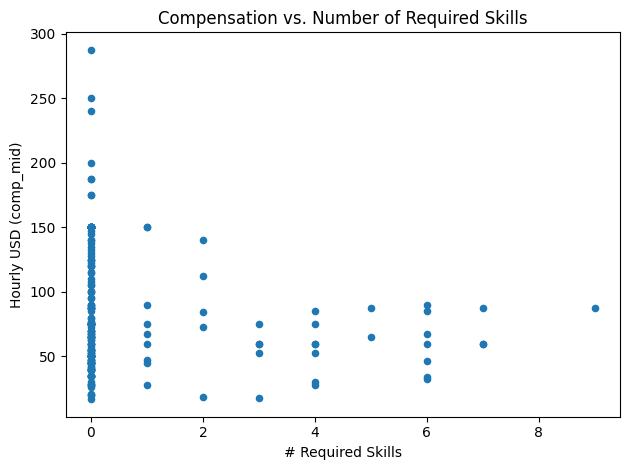

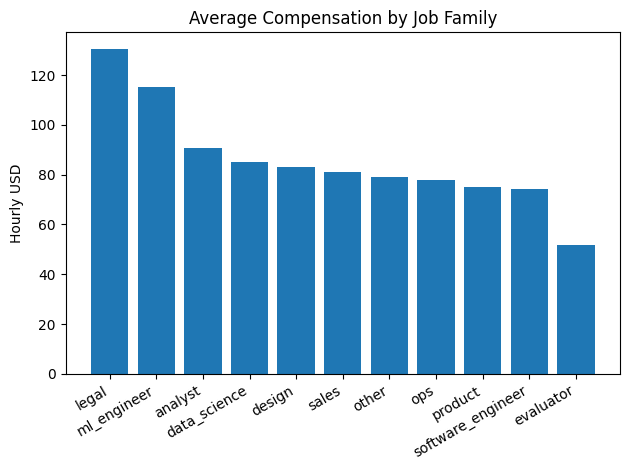

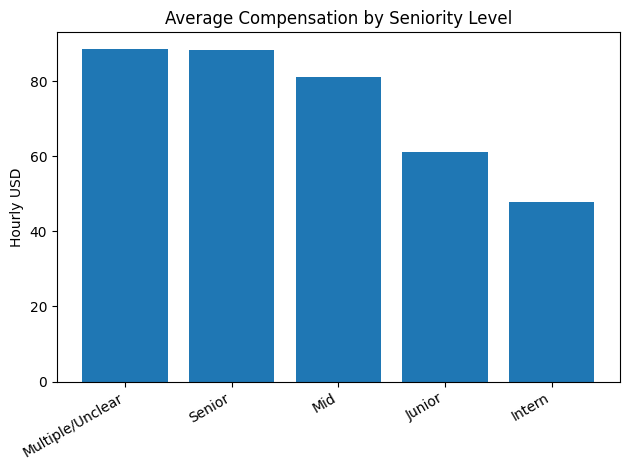

In [41]:

# =======================================
# 9. Pay vs. Skills / Families (Tradeoffs)
# =======================================
df['n_skills'] = df['required_technologies'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure()
plt.scatter(df['n_skills'].values, df['comp_mid'].values, s=20)
plt.title("Compensation vs. Number of Required Skills")
plt.xlabel("# Required Skills")
plt.ylabel("Hourly USD (comp_mid)")
plt.tight_layout()
plt.show()

if df['job_family'].nunique() > 1:
    fam_pay = df.groupby('job_family')['comp_mid'].mean().sort_values(ascending=False)
    plt.figure()
    plt.bar(fam_pay.index.tolist(), fam_pay.values.tolist())
    plt.xticks(rotation=30, ha='right')
    plt.title("Average Compensation by Job Family")
    plt.ylabel("Hourly USD")
    plt.tight_layout()
    plt.show()

if df['seniority_level'].nunique() > 1:
    sen_pay = df.groupby('seniority_level')['comp_mid'].mean().sort_values(ascending=False)
    plt.figure()
    plt.bar(sen_pay.index.tolist(), sen_pay.values.tolist())
    plt.xticks(rotation=30, ha='right')
    plt.title("Average Compensation by Seniority Level")
    plt.ylabel("Hourly USD")
    plt.tight_layout()
    plt.show()


In [42]:

# ======================================
# 10. Archetype Summaries per Cluster
# ======================================
def summarize_skill_cluster(cluster_id, df, X_bin, feature_names, topn=10):
    mask = (df['cluster_skills_kmeans'] == cluster_id)
    idx = np.where(mask.values)[0]
    if len(idx) == 0:
        return {}
    sums = X_bin[idx].sum(axis=0)
    top = sorted(zip(feature_names, sums), key=lambda kv: kv[1], reverse=True)[:topn]
    tops = [k for k,_ in top]
    subset_text = df.loc[mask, 'raw_text'].fillna('').tolist()
    vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
    try:
        X_sub = vectorizer.fit_transform(subset_text)
        centers = X_sub.mean(axis=0).A1
        terms = vectorizer.get_feature_names_out()
        top_terms_idx = np.argsort(centers)[::-1][:topn]
        top_terms = [terms[i] for i in top_terms_idx]
    except Exception:
        top_terms = []
    return {"top_skills": tops, "top_terms": top_terms, "count": int(mask.sum())}

archetypes = {}
if 'cluster_skills_kmeans' in df.columns and df['cluster_skills_kmeans'].nunique() > 1:
    for c in sorted(df['cluster_skills_kmeans'].unique()):
        if c == -1:
            continue
        archetypes[c] = summarize_skill_cluster(c, df, X_skills, skill_feature_names, topn=10)

print("Archetype summaries (skill-clusters):")
for c, summ in archetypes.items():
    print(f"Cluster {c}: count={summ.get('count')}")
    print("  top_skills:", summ.get('top_skills'))
    print("  top_terms :", summ.get('top_terms'))


Archetype summaries (skill-clusters):
Cluster 0: count=1
  top_skills: ['ADP', 'API', 'BambooHR', 'HRIS', 'Microsoft 365', 'SAP SuccessFactors', 'Workday', 'ANSYS', 'APIs', 'Adobe Creative Cloud']
  top_terms : ['systems', 'ai', 'interview', 'experience', 'mercor', 'hr', 'workflows', 'internal', 'help', 'response']
Cluster 1: count=198
  top_skills: ['Python', 'Go', 'Java', 'JavaScript', 'C++', 'Docker', 'React', 'TypeScript', 'Flask', 'Rust']
  top_terms : ['mercor', 'project', 'work', 'ai', 'based', 'role', 'experience', 'legal', 'hourly', 'applicants']


In [43]:

# ==================================================
# 11. (Optional) Candidate-pay-based filtering helper
# ==================================================
def filter_by_candidate_hourly(df, candidate_hourly_usd: float):
    mask = (df['comp_low'].astype(float) <= candidate_hourly_usd) & (candidate_hourly_usd <= df['comp_high'].astype(float))
    return df[mask].copy()

CANDIDATE_HOURLY = None  # e.g., 85.0
if CANDIDATE_HOURLY is not None:
    df_match = filter_by_candidate_hourly(df, CANDIDATE_HOURLY)
    print(f"Listings matching candidate hourly {CANDIDATE_HOURLY}: {len(df_match)}")
    display_cols = ['listing_id','title','company','comp_low','comp_high','job_family','seniority_level','work_mode']
    print(df_match[display_cols].head(20).to_string(index=False))


In [ ]:

# ============================
# 12. Save clustered DataFrame
# ============================
out_csv = os.path.join(OUTPUT_DIR, "job_listings_with_clusters.csv")
df.to_csv(out_csv, index=False)
print("Saved clustered listings to:", os.path.abspath(out_csv))
